In [1]:
import geemap as ge
import ee
from API.src import utils
import pandas as pd
import ipywidgets as widgets
import numpy as np
import ipyleaflet
import os
from ipyleaflet import VideoOverlay, DrawControl
from shapely.geometry import Point, MultiPoint
import geojson
from io import BytesIO
from ipywidgets import Layout
from IPython.core.display import display, HTML


C:\Users\jr725\AppData\Local\Temp\ipykernel_8328\2141203311.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
utils.clean_up_wd()

# Image Analysis Tool Alpha V0.1


In [3]:
#utils.clean_up_wd()

In [4]:
global input_poly_layer

In [5]:
try:
    ee.Initialize()
except:
    widgets.interact(ee.Authenticate())
    ee.Initialize()

In [6]:
Map = ge.Map(center=(19.432608, -99.133209), zoom=5, draw_ctrl=False, toolbar_ctrl=False, layer_ctrl=True)
Map
Map.add_basemap('HYBRID')
draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 0.1
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 0.1
    }
}

Map.add_control(draw_control)


In [7]:
def draw_callback(*args, **kwargs):
    try:
        Map.remove_layer(input_poly_layer)
    except:
        pass

In [8]:
draw_control.on_draw(draw_callback)

In [9]:
roi = ee.Feature(draw_control.last_draw['geometry'])

In [10]:
#roi = ee.FeatureCollection(Map.draw_features)

In [11]:
input_poly_layer_roi = None

In [12]:
frame = pd.DataFrame(columns=["Lat", "Lon"])

In [13]:
start_date_picker = widgets.DatePicker(
    description='Start Date',
    disabled=False
)

end_date_picker = widgets.DatePicker(
    description='End Date',
    disabled=False
)
date_controls = widgets.VBox([start_date_picker, end_date_picker])



# Image Quality Controls
cloud_cover_qual = widgets.IntSlider(
    value=100,
    min=0,
    max=100,
    step=1,
    description='Maximum Cloud Covier: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=Layout(width='100%', height='128px')
)


analysis_option_dropdown = widgets.Dropdown(options=["True Colour", "NBR", "NDVI", "Grey Green Blue Index"])
aggregation_option_dropdown = widgets.Dropdown(options=["None", 'Monthly', "Annual"], description="Aggregation Range")
aggregation_type_dropdown = widgets.Dropdown(options=["Mean", "Median", "Max"], description="Aggregation Type")

aggregationSubset = widgets.VBox([aggregation_option_dropdown, aggregation_type_dropdown])

imagery_accordion = widgets.Accordion([date_controls, cloud_cover_qual, analysis_option_dropdown, aggregationSubset])
imagery_accordion.set_title(0, "Date")
imagery_accordion.set_title(1, "Image Settings")
imagery_accordion.set_title(2, "Analysis Settings")
imagery_accordion.set_title(3, "Aggregation Settings")



geometry_reset = widgets.Button(
    description='Clear Geometry',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Clears map of all user input geometry',
    icon='broom', # (FontAwesome names without the `fa-` prefix)
    layout=Layout(width='95%')
)



geometry_file_upload = widgets.FileUpload(
    accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False,  # True to accept multiple files upload else False
    layout=Layout(width='95%')
)


lat_text_input = widgets.FloatText(
    value=0,
    description='Lat:',
    disabled=False
)

lon_text_input = widgets.FloatText(
    value=0,
    description='Lon:',
    disabled=False
)

add_csv_to_map = widgets.Button(description="Add File to Map", layout=Layout(width='95%'))
geom_upload_container = widgets.VBox([geometry_file_upload, add_csv_to_map])

latlon_frame = pd.DataFrame(columns=["Lat", "Lon"])
latlon_frame_display = widgets.Output(layout=Layout(width='95%'))

add_latlon_to_map = widgets.Button(description="Add Polygon to Map", layout=Layout(width='95%'))

add_latlon_button = widgets.Button(description="Add Point", layout=Layout(width='95%'))

lat_lon_input = widgets.VBox([add_latlon_to_map, latlon_frame_display, lat_text_input, lon_text_input, add_latlon_button])



annalyse_area_button = widgets.Button(description="Analyse", button_style="success", layout=Layout(width='99%'))


analysis_output = widgets.Accordion()
analysis_area = widgets.VBox([annalyse_area_button, analysis_output])

geometry_input_accordion = widgets.Accordion(children=[geom_upload_container, lat_lon_input])

geometry_input_accordion.set_title(0, "CSV Upload")
geometry_input_accordion.set_title(1, "Text Input")

geom_options_container = widgets.VBox([geometry_reset, geometry_input_accordion])


names = ["Imagery", "Geometry"]
tab = widgets.Tab(children = [imagery_accordion, geom_options_container])
for idx, n in enumerate(names):
    tab.set_title(idx, n)

In [14]:
def add_latlon_text_input(b):
    utils.add_new_latlon_row(latlon_frame, lat_text_input.value, lon_text_input.value)
    latlon_frame_display.clear_output()
    with latlon_frame_display:
        display(latlon_frame)
    


In [15]:
def add_uploaded_file_to_map(b):

    file_keys = list(geometry_file_upload.value.keys())
    uploaded_file = pd.read_csv(BytesIO(geometry_file_upload.value[file_keys[0]]['content']))

    # Get partial matching column names
    try:
        uploaded_file = uploaded_file[['Lat', 'Long']]
    except:
        uploaded_file = uploaded_file[['Lat', 'Lon']]
        
    global latlon_frame

    latlon_frame = uploaded_file


    if len(latlon_frame) > 0 :
    #print("valid frame")
        points = []

        for row in range(len(latlon_frame)):
            lon = latlon_frame['Lon'].values[row]

            lat = latlon_frame['Lat'].values[row]
            p = Point(lon, lat)

            points.append(p)


        mpt = MultiPoint([point for point in points])
        minimum_bounding_geom = mpt.convex_hull
        lon, lat = minimum_bounding_geom.exterior.coords.xy   
        
        mbg_to_leaflet = []
        mbg_to_geojson = []
        for i in range(len(lon)):
            mbg_to_leaflet.append((lat[i], lon[i]))
            mbg_to_geojson.append((lon[i], lat[i]))

        draw_control.clear()

        global input_poly_layer 
        input_poly_layer = ipyleaflet.Polygon(locations=mbg_to_leaflet, fillColor="#6be5c3",  color= "#6be5c3", fillOpacity=0.1)

        zoom_target = minimum_bounding_geom.representative_point()
        zoom_lon, zoom_lat = zoom_target.xy
        zoom_target = [zoom_lat[0], zoom_lon[0]]
        Map.center = zoom_target

        Map.add_layer(input_poly_layer)
        global input_poly_layer_roi
        input_poly_layer_roi = ee.Geometry.Polygon(mbg_to_geojson)
    else:
        print("invalid frame")

In [16]:
def add_text_input_to_map(b):
    if len(latlon_frame) > 0 :
        #print("valid frame")
        points = []
        
        for row in range(len(latlon_frame)):
            lon = latlon_frame['Lon'].values[row]
            
            lat = latlon_frame['Lat'].values[row]
            p = Point(lon, lat)
            
            points.append(p)
            
            
        mpt = MultiPoint([point for point in points])
        minimum_bounding_geom = mpt.convex_hull
        lon, lat = minimum_bounding_geom.exterior.coords.xy   


        mbg_to_leaflet = []
        mbg_to_geojson = []
        for i in range(len(lon)):
            mbg_to_leaflet.append((lat[i], lon[i]))
            mbg_to_geojson.append((lon[i], lat[i]))

        draw_control.clear()
        
        global input_poly_layer
        
        input_poly_layer = ipyleaflet.Polygon(locations=mbg_to_leaflet, fillColor="#6be5c3",  color= "#6be5c3", fillOpacity=0.1)
        
        zoom_target = minimum_bounding_geom.representative_point()
        zoom_lon, zoom_lat = zoom_target.xy
        zoom_target = [zoom_lat[0], zoom_lon[0]]
        Map.center = zoom_target
        
        Map.add_layer(input_poly_layer)
        global input_poly_layer_roi
        input_poly_layer_roi = ee.Geometry.Polygon(mbg_to_geojson)
        
        
    else:
        print("invalid frame")


In [17]:
def reset_geometry(b):
    latlon_frame_display.clear_output()
    global latlon_frame
    
    latlon_frame = latlon_frame[0:0]
    draw_control.clear()
    
    try:
        Map.remove_layer(input_poly_layer)
    except:
        pass

In [18]:
def reverse_geocode_area(lon, lat):
    locator = Nominatim(user_agent="jr725@exeter.ac.uk")
    coordinates = f"{lat}, {lon}"
    location = locator.reverse(coordinates)
    location_return = location.raw
    
    return location_return


In [19]:
def analyse_button(b):
    aggregation_mode = aggregation_option_dropdown.value
    aggregation_type = aggregation_type_dropdown.value

    image_mode = analysis_option_dropdown.value
    try:
        roi = ee.Feature(draw_control.last_draw['geometry']).bounds().geometry()
        bounds_frame = pd.DataFrame(np.array(roi.bounds().getInfo()['coordinates'][0]), columns=["Lon", "Lat"])

    except:
        roi = ee.Feature(input_poly_layer_roi).bounds().geometry()
        bounds_frame = pd.DataFrame(np.array(roi.bounds().getInfo()['coordinates'][0]), columns=["Lon", "Lat"])


    min_lon = bounds_frame['Lon'].min()
    max_lon = bounds_frame['Lon'].max()
    min_lat = bounds_frame['Lat'].min()
    max_lat = bounds_frame['Lat'].max()

    video_bounds = ((min_lat, min_lon), (max_lat, max_lon))





    lon, lat = roi.centroid(200).getInfo()['coordinates']
    area_string = utils.reverse_geocode_area(lon=lon, lat=lat)


    start = start_date_picker.value.strftime("%Y-%m-%d")
    end = end_date_picker.value.strftime("%Y-%m-%d")

    s2_vanilla = ee.ImageCollection("COPERNICUS/S2").filterDate(start, end).filterMetadata(
        'CLOUDY_PIXEL_PERCENTAGE', 'less_than',cloud_cover_qual.value)

    s2_vanilla = utils.get_imgcol_roi(s2_vanilla, roi)

    title = f"{area_string}, {start}-{end}, {image_mode}"



    dates = utils.ymdList(s2_vanilla)





    bands_order_dict = {"Burnt Area Index" : ['constant'],
                        "Grey Green Blue Index":["red", "green", "blue"],
                        "True Colour" : ['B4',  'B3', 'B2'],
                        "NBR" : ['constant',"B3","B2"],
                        "NDVI" : ["B4", 'constant', "B2"]}


    aggregation_options_dict = {"Monthly": utils.aggregate_monthly(s2_vanilla, dates, aggregation_type),
                       "Annual": utils.aggregate_anually(s2_vanilla, dates, aggregation_type),
                       "None": (s2_vanilla, dates)}

    GeneratedCollection, dates = aggregation_options_dict[aggregation_mode]



    saved_gif = title+".gif"

    saved_gif = os.path.join(os.path.dirname(os.getcwd()), saved_gif)

    #print(utils.ymdList(image_col_dict[image_mode]))
    print("Generating Gif")


    image_col_dict = {"Burnt Area Index": GeneratedCollection.map(utils.get_BAIS2),
                        "Grey Green Blue Index": GeneratedCollection.map(utils.get_Green_Grey_Blue_Index),
                      "True Colour": GeneratedCollection.map(lambda x: x.divide(10000)),
                      "NBR": GeneratedCollection.map(utils.add_NBR).map(utils.reproject_to_calc_band),
                      "NDVI": GeneratedCollection.map(utils.add_NDVI).map(utils.reproject_to_calc_band)}
    GeneratedCollection = image_col_dict[image_mode]
    selected_bands = bands_order_dict[image_mode]



    framePaths = utils.download_gif(GeneratedCollection.select(selected_bands).map(lambda x: x.clip(roi)), title)

    print("Gif generated")
    ge.add_text_to_gif(saved_gif, saved_gif, xy=('0%', '0%'), text_sequence=dates, font_color='white', duration=1000)
    #ge.add_text_to_gif(saved_gif, saved_gif, xy=('0%', '10%'), text_sequence=title, font_color='white', duration=1000)

    gif_overlay = ge.ImageOverlay(url=saved_gif, bounds=video_bounds, name=title)
    Map.add_layer(gif_overlay)
    analysis = utils.Area_Analysis(image_col_dict[image_mode], saved_gif, title, bands_order_dict[image_mode], roi, image_mode, 
                                   dates, framePaths)
    
    roi_analysis = analysis.display()
    #analysis_download = 
    
    button_output = widgets.Output()
    #'with button_output:
    #    display(HTML(analysis.export()))
    
    analysis_container = widgets.HBox([roi_analysis, button_output])
    
    analysis_output.children = [*analysis_output.children, analysis_container]
    analysis_output.set_title(len(analysis_output.children)-1, title)
    
    
    

In [20]:
add_latlon_to_map.on_click(add_text_input_to_map)

In [21]:
annalyse_area_button.on_click(analyse_button)

In [22]:
add_latlon_button.on_click(add_latlon_text_input)

In [23]:
geometry_reset.on_click(reset_geometry)

In [24]:
add_csv_to_map.on_click(add_uploaded_file_to_map)

AppLayout(children=(Button(button_style='success', description='Analyse', layout=Layout(grid_area='footer', wi…

Generating Gif
200
200
Gif generated


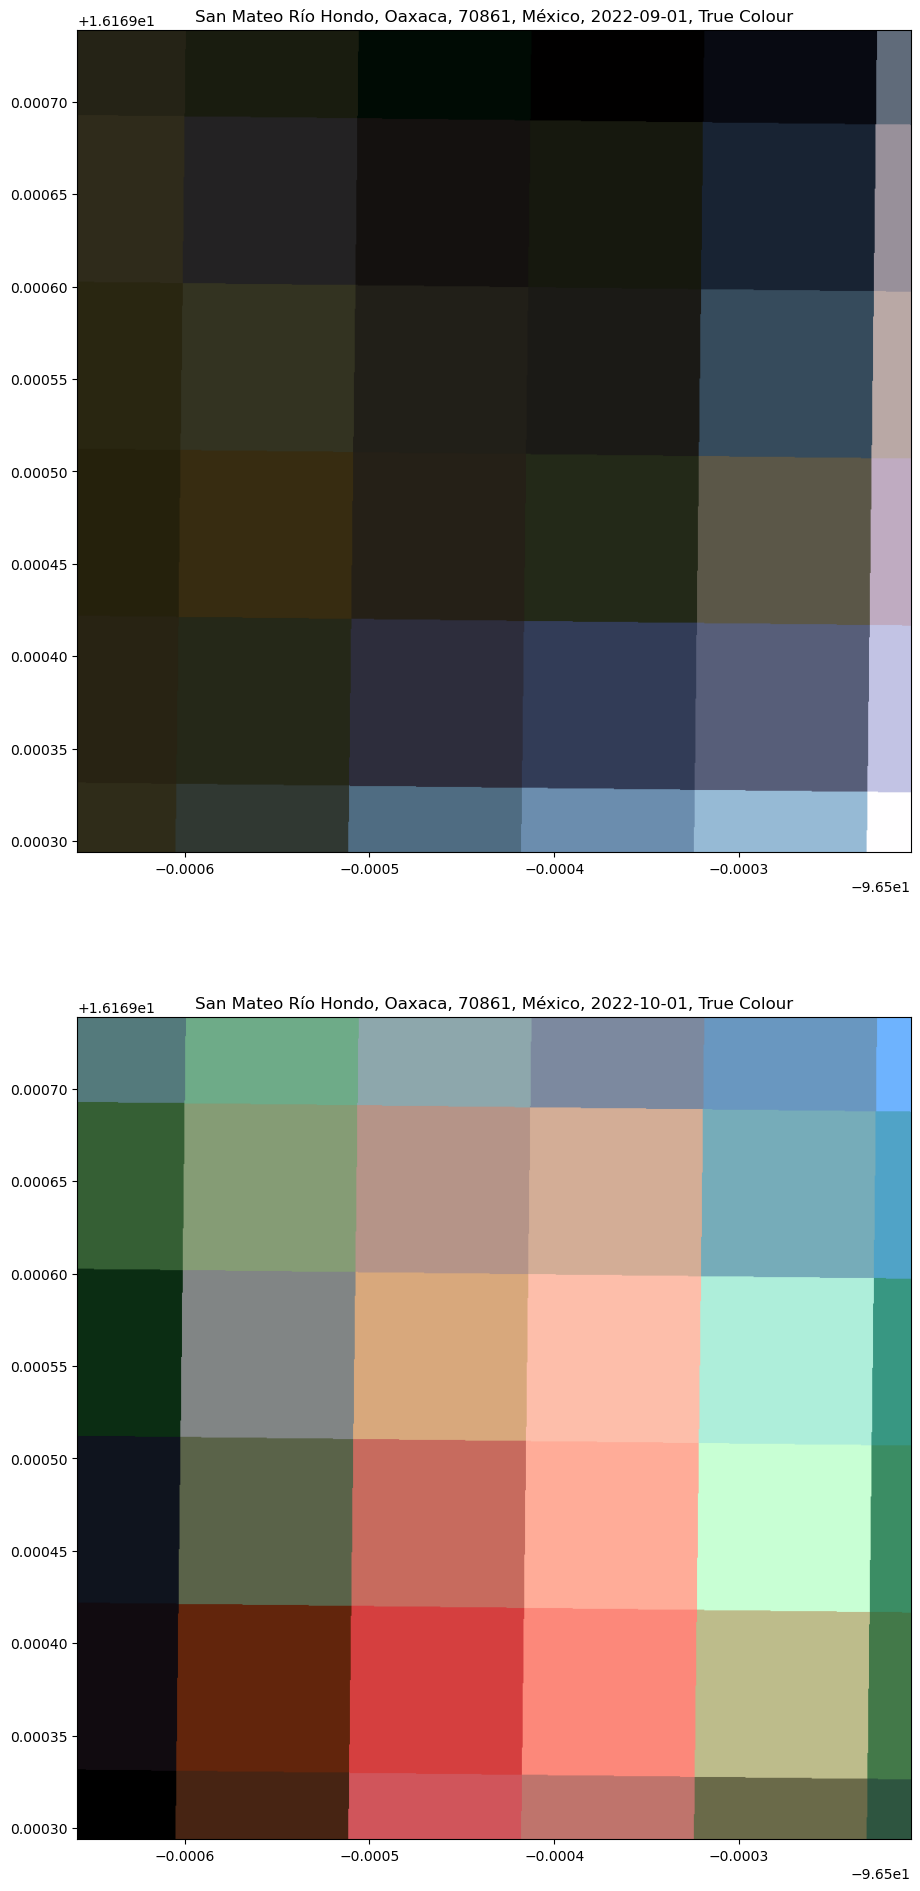

In [25]:
widgets.AppLayout(header=None,
          left_sidebar=None,
          center=Map,
          pane_widths=[1, 5, 3],
          pane_heights=[1,8,1],
          right_sidebar=tab,
          footer=annalyse_area_button)



In [26]:
analysis_output

Accordion()

In [27]:

saved_gif = os.path.dirname(os.getcwd()) + '/../../../'+"title"+".gif"

relative_gif_path = os.path.join(os.path.dirname(os.getcwd()), saved_gif)


In [28]:

    saved_gif = "title"+".gif"

    saved_gif = os.path.join(os.path.dirname(os.getcwd()), saved_gif)

In [29]:
saved_gif

'C:\\Users\\jr725\\Astraea\\title.gif'